In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

In [ ]:
# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Biến đổi dữ liệu
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='../CDIO_3/chest_xray/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='../CDIO_3/chest_xray/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
# Sử dụng CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter()

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) 
model = model.to(device)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy(inputs, targets) 
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
# Dùng Focal Loss và AdamW optimizer
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter()

In [ ]:
# Huấn luyện
def train(epoch):
    model.train()
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 50 == 0:
            writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

    accuracy = 100 * correct / total
    writer.add_scalar('Accuracy/train', accuracy, epoch)
    print(f"Train Accuracy at Epoch {epoch}: {accuracy:.2f}%")  # In accuracy trong quá trình huấn luyện

Train Accuracy at Epoch 1: 93.14%
Test Accuracy at Epoch 1: 91.67%
Confusion Matrix:
[[183  51]
 [  1 389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.88       234
           1       0.88      1.00      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.89      0.91       624
weighted avg       0.93      0.92      0.91       624



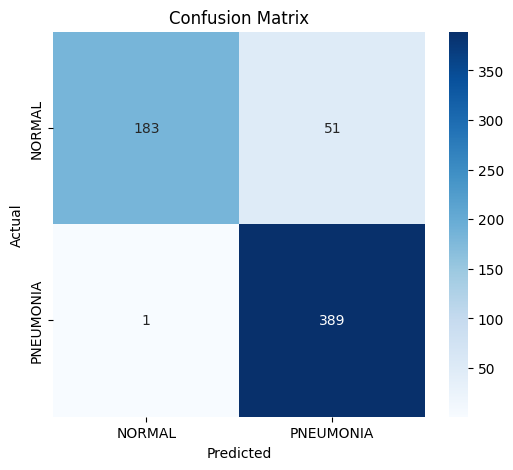

Train Accuracy at Epoch 2: 95.64%
Test Accuracy at Epoch 2: 94.39%
Confusion Matrix:
[[222  12]
 [ 23 367]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       234
           1       0.97      0.94      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.95      0.94      0.94       624



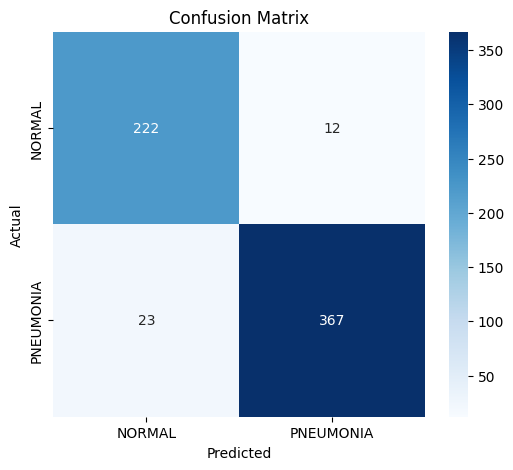

Train Accuracy at Epoch 3: 95.76%
Test Accuracy at Epoch 3: 90.22%
Confusion Matrix:
[[177  57]
 [  4 386]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       234
           1       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



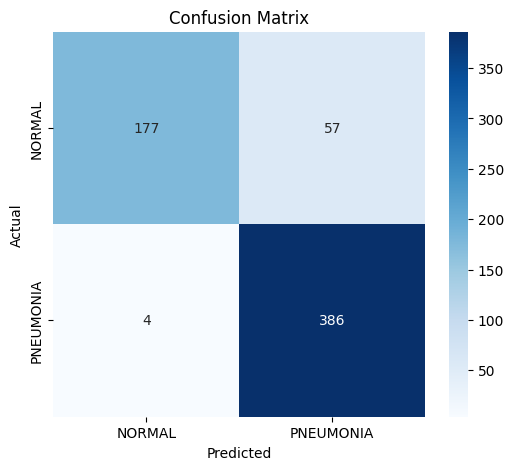

Train Accuracy at Epoch 4: 96.44%
Test Accuracy at Epoch 4: 91.19%
Confusion Matrix:
[[181  53]
 [  2 388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       234
           1       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



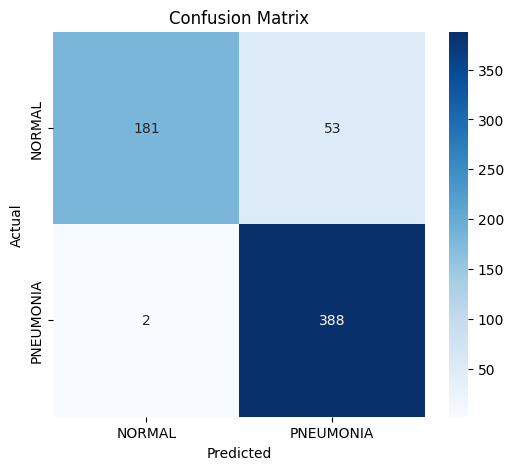

Train Accuracy at Epoch 5: 97.06%
Test Accuracy at Epoch 5: 88.46%
Confusion Matrix:
[[163  71]
 [  1 389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       234
           1       0.85      1.00      0.92       390

    accuracy                           0.88       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.88      0.88       624



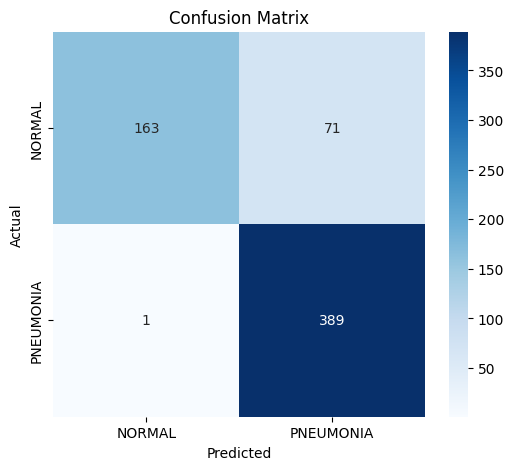

Train Accuracy at Epoch 6: 97.50%
Test Accuracy at Epoch 6: 92.47%
Confusion Matrix:
[[189  45]
 [  2 388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       234
           1       0.90      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.90      0.92       624
weighted avg       0.93      0.92      0.92       624



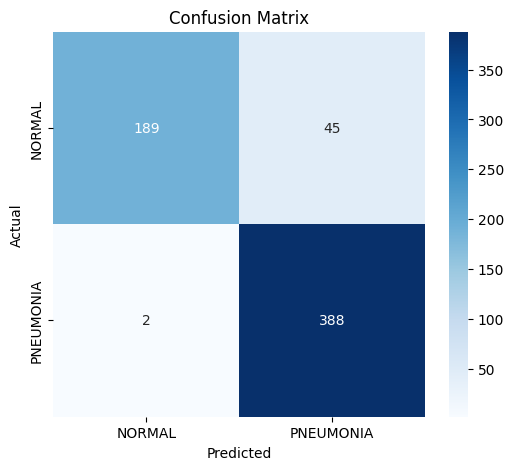

Train Accuracy at Epoch 7: 97.65%
Test Accuracy at Epoch 7: 89.42%
Confusion Matrix:
[[170  64]
 [  2 388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       234
           1       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.91      0.89      0.89       624



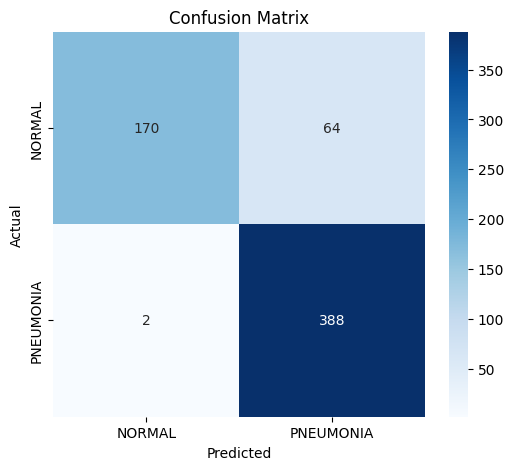

Train Accuracy at Epoch 8: 97.73%
Test Accuracy at Epoch 8: 93.91%
Confusion Matrix:
[[198  36]
 [  2 388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       234
           1       0.92      0.99      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



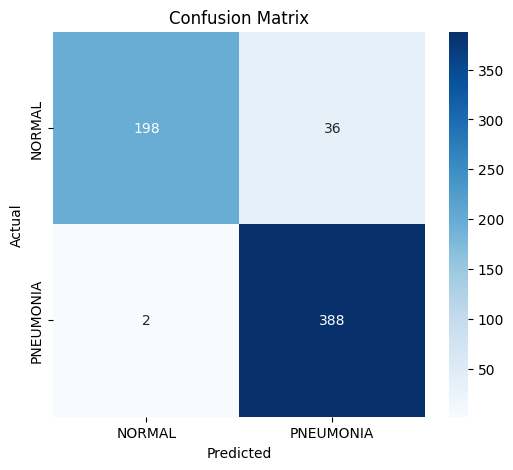

Train Accuracy at Epoch 9: 97.74%
Test Accuracy at Epoch 9: 92.63%
Confusion Matrix:
[[191  43]
 [  3 387]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       234
           1       0.90      0.99      0.94       390

    accuracy                           0.93       624
   macro avg       0.94      0.90      0.92       624
weighted avg       0.93      0.93      0.92       624



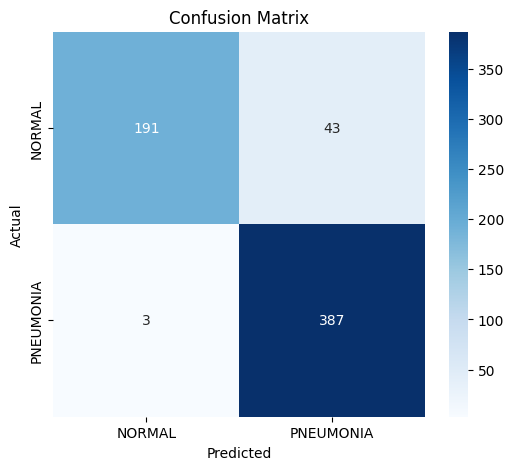

Train Accuracy at Epoch 10: 98.15%
Test Accuracy at Epoch 10: 85.58%
Confusion Matrix:
[[145  89]
 [  1 389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       234
           1       0.81      1.00      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



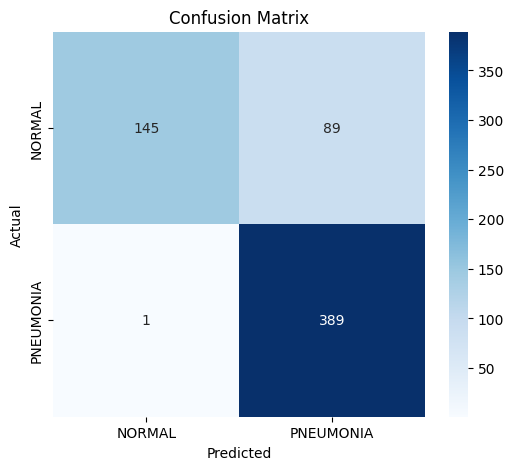

Train Accuracy at Epoch 11: 97.92%
Test Accuracy at Epoch 11: 92.95%
Confusion Matrix:
[[223  11]
 [ 33 357]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       234
           1       0.97      0.92      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



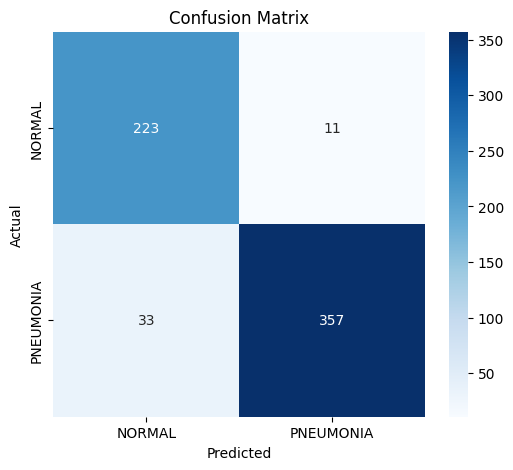

Train Accuracy at Epoch 12: 97.32%
Test Accuracy at Epoch 12: 73.56%
Confusion Matrix:
[[ 69 165]
 [  0 390]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.29      0.46       234
           1       0.70      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.64       624
weighted avg       0.81      0.74      0.69       624



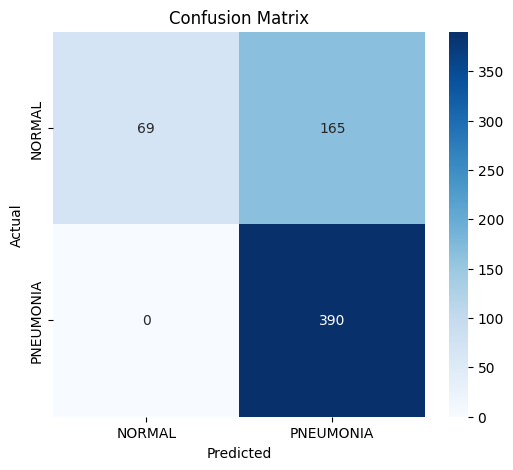

Train Accuracy at Epoch 13: 97.76%
Test Accuracy at Epoch 13: 93.59%
Confusion Matrix:
[[200  34]
 [  6 384]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       234
           1       0.92      0.98      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.94      0.94      0.93       624



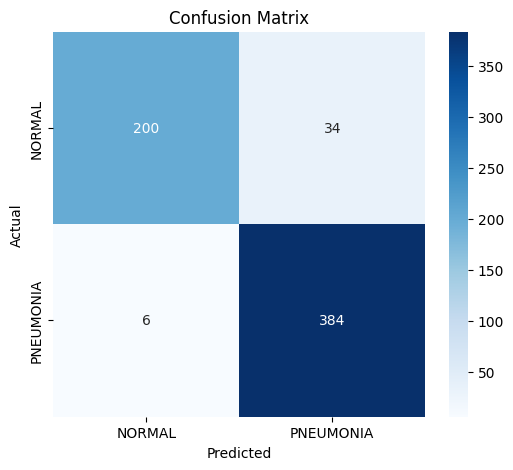

Train Accuracy at Epoch 14: 98.43%
Test Accuracy at Epoch 14: 91.03%
Confusion Matrix:
[[179  55]
 [  1 389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       234
           1       0.88      1.00      0.93       390

    accuracy                           0.91       624
   macro avg       0.94      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



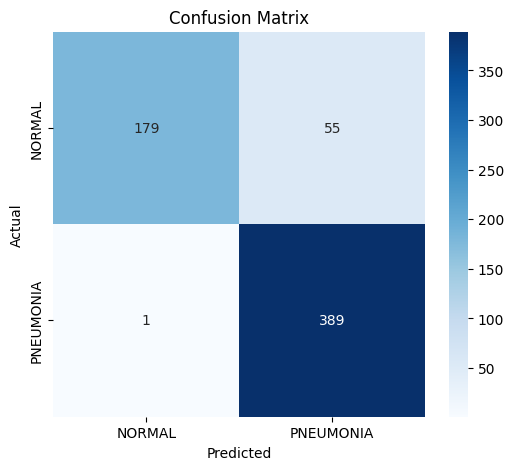

Train Accuracy at Epoch 15: 98.13%
Test Accuracy at Epoch 15: 70.51%
Confusion Matrix:
[[ 50 184]
 [  0 390]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       234
           1       0.68      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.84      0.61      0.58       624
weighted avg       0.80      0.71      0.64       624



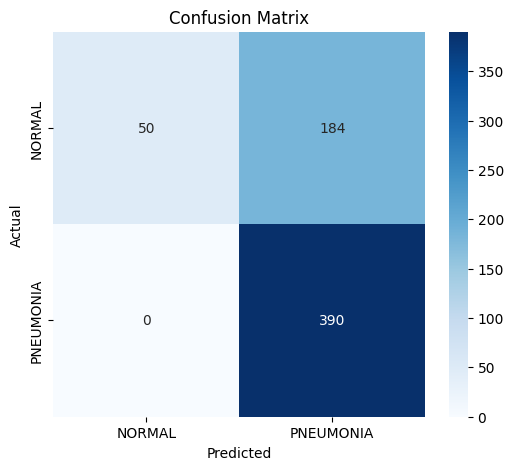

Train Accuracy at Epoch 16: 97.99%
Test Accuracy at Epoch 16: 88.62%
Confusion Matrix:
[[165  69]
 [  2 388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.82       234
           1       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



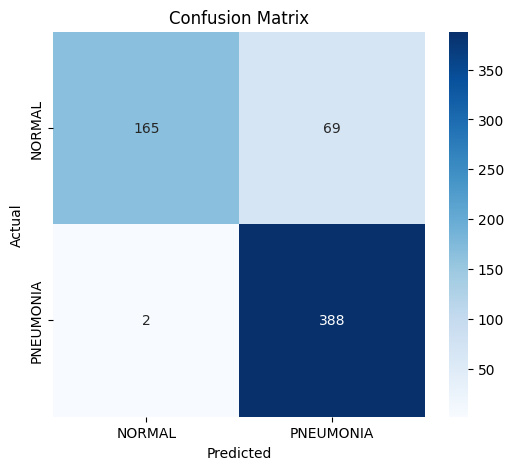

Train Accuracy at Epoch 17: 97.19%
Test Accuracy at Epoch 17: 95.51%
Confusion Matrix:
[[214  20]
 [  8 382]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       234
           1       0.95      0.98      0.96       390

    accuracy                           0.96       624
   macro avg       0.96      0.95      0.95       624
weighted avg       0.96      0.96      0.95       624



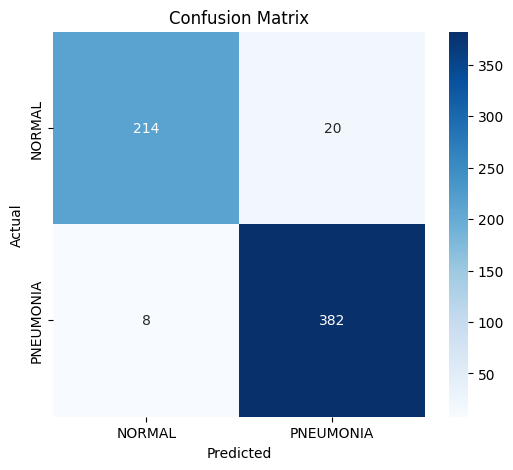

Train Accuracy at Epoch 18: 97.90%
Test Accuracy at Epoch 18: 84.94%
Confusion Matrix:
[[141  93]
 [  1 389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       234
           1       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



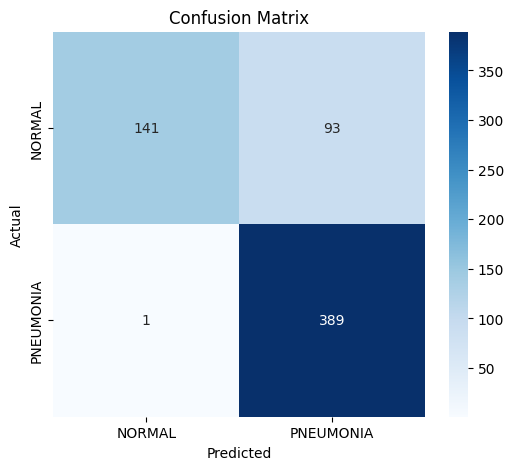

Train Accuracy at Epoch 19: 98.01%
Test Accuracy at Epoch 19: 86.22%
Confusion Matrix:
[[148  86]
 [  0 390]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       234
           1       0.82      1.00      0.90       390

    accuracy                           0.86       624
   macro avg       0.91      0.82      0.84       624
weighted avg       0.89      0.86      0.85       624



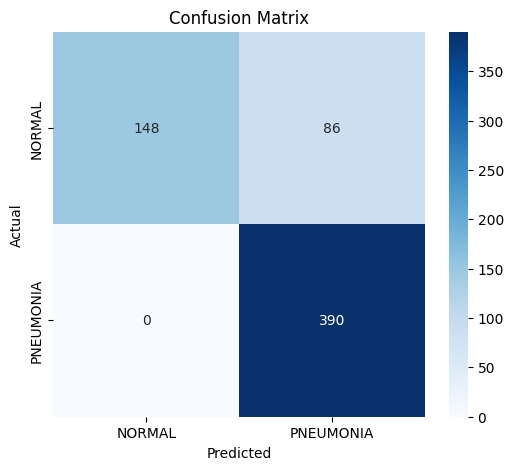

Train Accuracy at Epoch 20: 98.22%
Test Accuracy at Epoch 20: 94.71%
Confusion Matrix:
[[204  30]
 [  3 387]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       234
           1       0.93      0.99      0.96       390

    accuracy                           0.95       624
   macro avg       0.96      0.93      0.94       624
weighted avg       0.95      0.95      0.95       624



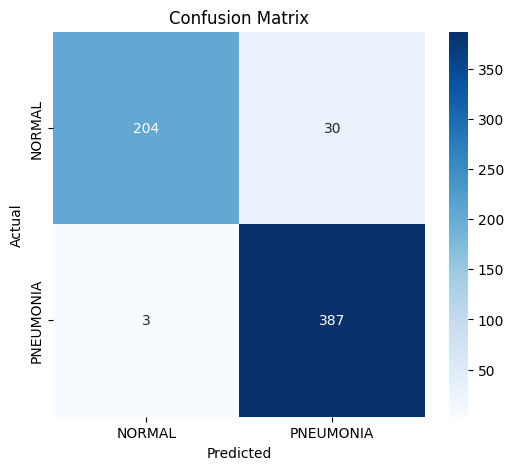

In [ ]:
# Đánh giá
def evaluate(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/test', accuracy, epoch)

    
    print(f"Test Accuracy at Epoch {epoch}: {accuracy:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds)) 

    # Vẽ Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy 

    # Thêm tính toán AUC-ROC nếu đây là bài toán phân loại nhị phân
    if len(test_dataset.classes) == 2:
        y_score = torch.softmax(output, dim=1).cpu().numpy()[:, 1]
        auc = roc_auc_score(all_labels, y_score)
        print(f"AUC-ROC: {auc:.4f}")
        
        writer.add_scalar('AUC-ROC/test', auc, epoch)

# Vòng lặp huấn luyện với early stopping
num_epochs = 20
best_accuracy = 0
early_stopping_patience = 3
no_improvement = 0

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train(epoch)  # Huấn luyện
    accuracy = evaluate(epoch)  # Đánh giá

    if accuracy is None: 
        print(f"Warning: Accuracy is None at epoch {epoch}. Skipping...")
        continue
        scheduler.step()
        # Lưu model tốt nhất 
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Lưu model tốt nhất
        with open('best_epoch.txt', 'w') as f:
            f.write(str(epoch))  # Lưu epoch tốt nhất
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= early_stopping_patience:
        print("Early stopping due to no improvement in validation accuracy.")
        break

    print(f'Epoch {epoch} time: {time.time() - start_time:.2f}s')

print("Training complete. Best model saved.")
writer.close()

In [ ]:
import torch

# Tải lại mô hình tốt nhất
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Đặt chế độ đánh giá

# Tải lại số epoch tốt nhất
best_epoch = None
with open('best_epoch.txt', 'r') as f:
    best_epoch = int(f.read().strip())

# In thông số của mô hình
def print_model_parameters(model):
    print("\nThông số của mô hình tốt nhất:\n")
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()} | requires_grad={param.requires_grad}")
    
    print(f"\nMô hình tốt nhất đạt được tại epoch: {best_epoch}\n")

print_model_parameters(model)



Thông số của mô hình tốt nhất:

conv1.weight: torch.Size([64, 3, 7, 7]) | requires_grad=True
bn1.weight: torch.Size([64]) | requires_grad=True
bn1.bias: torch.Size([64]) | requires_grad=True
layer1.0.conv1.weight: torch.Size([64, 64, 3, 3]) | requires_grad=True
layer1.0.bn1.weight: torch.Size([64]) | requires_grad=True
layer1.0.bn1.bias: torch.Size([64]) | requires_grad=True
layer1.0.conv2.weight: torch.Size([64, 64, 3, 3]) | requires_grad=True
layer1.0.bn2.weight: torch.Size([64]) | requires_grad=True
layer1.0.bn2.bias: torch.Size([64]) | requires_grad=True
layer1.1.conv1.weight: torch.Size([64, 64, 3, 3]) | requires_grad=True
layer1.1.bn1.weight: torch.Size([64]) | requires_grad=True
layer1.1.bn1.bias: torch.Size([64]) | requires_grad=True
layer1.1.conv2.weight: torch.Size([64, 64, 3, 3]) | requires_grad=True
layer1.1.bn2.weight: torch.Size([64]) | requires_grad=True
layer1.1.bn2.bias: torch.Size([64]) | requires_grad=True
layer2.0.conv1.weight: torch.Size([128, 64, 3, 3]) | require